In [34]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F

In [35]:
df = pd.read_csv('iris.csv')

In [36]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Building the ANN Class

In [37]:
class Model(nn.Module):

    def __init__(self,in_features=4,h1=8,h2=9,out_features=3):
        #how many layers we need
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.out = nn.Linear(h2,out_features)
        

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

In [25]:
torch.manual_seed(32)
model = Model()

In [26]:
features = df.drop('target',axis=1).values
labels = df['target'].values

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.2,random_state=33)

In [49]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Defining the loss and optimizer

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In case our loss isnt improving we can try by reducing the learning rate

In [53]:
model.parameters()

<generator object Module.parameters at 0x000001B70F1D6880>

In [54]:
from torch.utils.data import DataLoader,TensorDataset
iris = TensorDataset(torch.FloatTensor(features),torch.LongTensor(labels))
iris_loader = DataLoader(iris,batch_size = 15, shuffle=True)

### Training the model

Usually for mutliclass classification problems, we need to do one-hot encoding during data preprocessing . But for pytorch if we consider the cross-entropy loss function this step isn't needed

Deciding the number of epochs(start small and increase if performance is not satisfactory)

In [55]:
epochs = 100
losses = []

for i in range(epochs):
    i = i+1

    #Obtain Prediction
    y_pred = model.forward(X_train)

    #calculate loss and append it to the list
    loss = criterion(y_pred,y_train)

    losses.append(loss.item())

    if i%10 ==0:
        print(f"epoch {i} loss:{loss.item()}")

    #Zero out the gradients to avoid cluttering during backpropagation
    optimizer.zero_grad()

    #Backpropagate the loss
    loss.backward()

    #Update the hyperparameters
    optimizer.step()

epoch 10 loss:0.9566181898117065
epoch 20 loss:0.7923727631568909
epoch 30 loss:0.6320289373397827
epoch 40 loss:0.4185295104980469
epoch 50 loss:0.26722967624664307
epoch 60 loss:0.15835252404212952
epoch 70 loss:0.1040063425898552
epoch 80 loss:0.08255429565906525
epoch 90 loss:0.07298815250396729
epoch 100 loss:0.06756164133548737


Plotting Loss vs Epoch

Text(0, 0.5, 'Epoch')

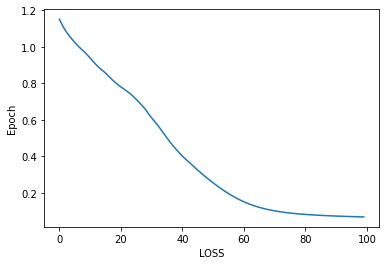

In [56]:
plt.plot(range(epochs),losses)
plt.xlabel('LOSS')
plt.ylabel('Epoch')

### Evaluating Model Performance

Gradient won't be calculated for code chunks under torch.no_grad(). This helps in improving memory utilisation

In [57]:
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval,y_test)

In [58]:
loss

tensor(0.0581)

In [64]:
correct = 0

with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)

        #y_val is a tensor, cant print directly hence use str
        print(f'{i+1}.)  {str(y_val)}   {y_test[i]}')
        #First is for serial number, next we obtain the tensor with values for each class
        # Class with the highest value is the predicted class. y_test[i] is the actual class for that particular sample

        #Counting the number of current predictions
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'We got {correct} correct')

1.)  tensor([-2.1252,  4.8064, -0.8628])   1
2.)  tensor([-1.7985,  5.3098, -1.5449])   1
3.)  tensor([  6.3542,   0.8438, -10.0541])   0
4.)  tensor([-3.9123,  4.5958,  1.1693])   1
5.)  tensor([-7.4713,  3.2021,  5.7853])   2
6.)  tensor([-10.4976,   1.6459,   9.6297])   2
7.)  tensor([  6.3201,   0.9917, -10.1532])   0
8.)  tensor([  7.0468,   0.7059, -10.9137])   0
9.)  tensor([-7.2061,  3.3477,  5.3565])   2
10.)  tensor([-9.3960,  2.5759,  8.1033])   2
11.)  tensor([-9.8808,  2.3475,  8.7141])   2
12.)  tensor([ 6.2748,  0.6655, -9.7613])   0
13.)  tensor([-9.3142,  2.1880,  8.1947])   2
14.)  tensor([-3.7803,  4.5050,  1.0752])   1
15.)  tensor([-7.8657,  3.0117,  6.2303])   2
16.)  tensor([-1.8867,  5.1572, -1.3345])   1
17.)  tensor([-5.7006,  3.5030,  3.6696])   2
18.)  tensor([  7.1789,   0.7369, -11.1350])   0
19.)  tensor([-3.2944,  4.7931,  0.3475])   1
20.)  tensor([-7.7665,  3.7629,  5.7095])   2
21.)  tensor([  6.6499,   0.7889, -10.4252])   0
22.)  tensor([  7.4357,  

Saving the model

In [65]:
torch.save(model.state_dict(),'my_iris_model.pt')

state_dict holds all the learned parameters of the model

Loading a pre-saved dictionary

In [66]:
new_model = Model()
new_model.load_state_dict(torch.load('my_iris_model.pt'))

<All keys matched successfully>

In [67]:
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In case we need to save the entire model including the model class:

`torch.save(model,'my_iris_model_complete.pt')`

Using this model on new data(unseen by the model)

In [69]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

The following code visualizes the mystery point wrt the existing points:

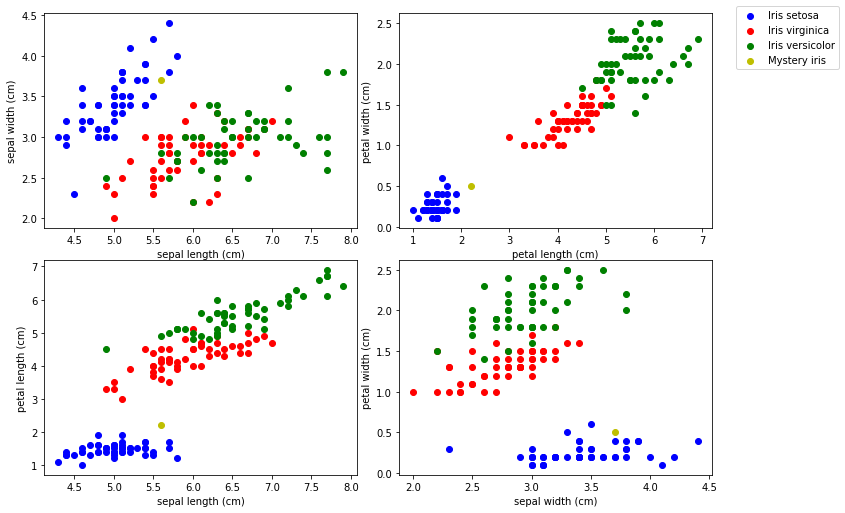

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [75]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print(f'The mystery point belongs to class {new_model(mystery_iris).argmax().item()}')

tensor([  5.9522,   1.5596, -10.0054])
The mystery point belongs to class 0
